In [1]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [2]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'
    

In [3]:
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
print('Before:'+str(beh.shape))

beh['DX_01'].nunique()


Before:(3076, 177)


64

In [8]:
beh['DX_01'].value_counts()


ADHD-Combined Type                                       616
ADHD-Inattentive Type                                    567
No Diagnosis Given                                       282
Autism Spectrum Disorder                                 239
Specific Learning Disorder with Impairment in Reading    194
                                                        ... 
Depressive Disorder Due to Another Medical Condition       1
Delirium due to another medical condition                  1
Gender Dysphoria in Children                               1
Parent-Child Relational Problem                            1
Cyclothymic Disorder                                       1
Name: DX_01, Length: 64, dtype: int64

In [11]:
beh = pd.read_csv(DATA_DIR+"behaviorals.csv")
print('Before:'+str(beh.shape))

most_common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders',  'No Diagnosis Given', 'Other Disorders']

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)] +\
                   ['DX_' + str(i).zfill(2) + '_Sub' for i in range(1, 11)]

# removing patients with incomplete eval
initial_size = beh.shape[0]
beh = beh[beh.DX_01 != 'No Diagnosis Given: Incomplete Eval']
beh = beh.reset_index(drop=True)
new_size = beh.shape[0]

print('After:'+str(beh.shape))
print('Removing', initial_size - new_size,
      'patients as their evaluations was incomplete.')

Before:(3076, 177)
After:(2939, 177)
Removing 137 patients as their evaluations was incomplete.


In [12]:
max(beh['Age']) #max age: 21.816563, min age: 5.016997


21.816563

In [13]:
beh.columns

Index(['Unnamed: 0', 'IDs', 'Age', 'Sex', 'ACE_Score', 'APQ_P_Total',
       'APQ_SR_Total', 'ARI_P_Total_Score', 'ARI_S_Total_Score', 'ASSQ_Total',
       ...
       'DX_10_PRem', 'DX_10_Past_Doc', 'DX_10_Presum', 'DX_10_RC', 'DX_10_Rem',
       'DX_10_RuleOut', 'DX_10_Spec', 'DX_10_Sub', 'DX_10_Time', 'NoDX'],
      dtype='object', length=177)

In [27]:
no_diagnosis_given = 'No Diagnosis Given'
diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}
diagnoses_to_ids

{'Attention-Deficit/Hyperactivity Disorder': 0,
 'Anxiety Disorders': 1,
 'Specific Learning Disorder': 2,
 'Autism Spectrum Disorder': 3,
 'Disruptive': 4,
 'Communication Disorder': 5,
 'Depressive Disorders': 6,
 'No Diagnosis Given': 7,
 'Other Disorders': 8}

In [28]:
def get_disorder(data, row, index):
    disorder = data.iloc[row][category_columns[index]]

    if disorder == 'Neurodevelopmental Disorders':
        disorder = data.iloc[row][category_columns[index + 10]]

    return disorder

order_of_disorders = []
for k in range(beh.shape[0]):
    i = 0
    disorder = get_disorder(beh, k, i)
    disorders_patient = []
    while not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        else:
            if diagnoses_to_ids['Other Disorders'] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids['Other Disorders'])
        i += 1
        if i == len(category_columns):
            break
        disorder = get_disorder(beh, k, i)

        
    order_of_disorders.append(disorders_patient)

In [29]:
other_disorders = []
no_diagnosis_given = []
for i in order_of_disorders:
    if 7 in i:
        no_diagnosis_given.append(1)
        i.remove(7)
    else:
        no_diagnosis_given.append(0)
    if 8 in i:
        other_disorders.append(1)
        i.remove(8)
    else:
        other_disorders.append(0)

In [30]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

classes = np.zeros((len(most_common_disorders),
                    beh.shape[0]), dtype=np.int32)

df_disorders = beh[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

behaviour_data_columns = beh.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = beh.drop(columns=columns_to_drop)

for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [31]:
common_disorders = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders']

labels=behaviour_data[["IDs"]+list(common_disorders)]
labels["Other Disorders"] = other_disorders
labels

/tmp/ipykernel_1139538/226828375.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Other Disorders"] = other_disorders


,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders
0,NDARAA075AMK,0,0,0,0,0,0,0,0
1,NDARAA112DMH,1,0,0,0,1,0,0,1
2,NDARAA117NEJ,1,0,0,0,1,0,0,1
3,NDARAA306NT2,1,1,1,0,0,1,0,1
4,NDARAA504CRN,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
2934,NDARZZ007YMP,0,0,0,1,0,0,0,1
2935,NDARZZ740MLM,1,0,0,0,0,0,0,0
2936,NDARZZ810LVF,0,0,0,1,0,1,0,1
2937,NDARZZ830JM7,0,0,0,1,0,0,0,1


In [32]:
add_features = behaviour_data[['Sex', 'Age','IDs']]
add_features.shape

(2939, 3)

In [33]:

df = pd.merge(labels, add_features, on='IDs', how='inner')
df

,IDs,Attention-Deficit/Hyperactivity Disorder,Anxiety Disorders,Specific Learning Disorder,Autism Spectrum Disorder,Disruptive,Communication Disorder,Depressive Disorders,Other Disorders,Sex,Age
0,NDARAA075AMK,0,0,0,0,0,0,0,0,1,6.728040
1,NDARAA112DMH,1,0,0,0,1,0,0,1,0,5.545744
2,NDARAA117NEJ,1,0,0,0,1,0,0,1,0,7.475929
3,NDARAA306NT2,1,1,1,0,0,1,0,1,1,21.216746
4,NDARAA504CRN,1,1,1,0,0,0,0,1,1,9.165297
...,...,...,...,...,...,...,...,...,...,...,...
2934,NDARZZ007YMP,0,0,0,1,0,0,0,1,1,16.033994
2935,NDARZZ740MLM,1,0,0,0,0,0,0,0,0,6.638261
2936,NDARZZ810LVF,0,0,0,1,0,1,0,1,0,8.502623
2937,NDARZZ830JM7,0,0,0,1,0,0,0,1,0,13.121492


### Data Split

In [34]:
disorders_list = ['Attention-Deficit/Hyperactivity Disorder', 'Anxiety Disorders', 'Specific Learning Disorder',
                         'Autism Spectrum Disorder', 'Disruptive', 'Communication Disorder',
                         'Depressive Disorders', 'Other Disorders']
                         
#rest_list = ['Age','Sex']            
x = df[df.columns.difference(['IDs']+disorders_list)]
        
#x = df[df.columns.difference(['IDs']+disorders_list + rest_list)]
y = df[disorders_list]

# summarize dataset shape
print(x.shape, y.shape)

(2939, 2) (2939, 8)


In [35]:
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.25, shuffle=True)

In [36]:
train_labels = np. array(train_labels) 
test_labels = np. array(test_labels) 

In [37]:
print(train_features.shape, test_features.shape)

(2204, 2) (735, 2)


In [38]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(2204, 2) (735, 2)


In [39]:
train_labels.sum(axis=0)


array([1369,  734,  512,  354,  341,  324,  237,  869])

In [40]:
test_labels.sum(axis=0)

array([471, 253, 169, 133, 114, 126,  50, 303])

### Metrics

In [41]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")

    plt.show()
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [42]:
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

def brier_multi(targets, probs):
    return np.mean(np.sum((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Hamming Loss:", hamming_loss(y_test, y_pred))
    if brier:
        print("Brier Score:", brier_multi(y_test, y_pred_prob))
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))

## Models

### Multi Output Classifier

LogisticRegression():
Accuracy: 0.13197278911564625
Hamming Loss: 0.2403061224489796
Brier Score: 1.3380331972946256
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.87      0.76       471
           1       0.50      0.07      0.12       253
           2       1.00      0.00      0.00       169
           3       1.00      0.00      0.00       133
           4       1.00      0.00      0.00       114
           5       1.00      0.00      0.00       126
           6       0.29      0.04      0.07        50
           7       1.00      0.00      0.00       303

   micro avg       0.66      0.26      0.38      1619
   macro avg       0.81      0.12      0.12      1619
weighted avg       0.80      0.26      0.24      1619
 samples avg       0.70      0.37      0.38      1619

Confusion matrix:
 [[[ 63 201]
  [ 61 410]]

 [[465  17]
  [236  17]]

 [[566   0]
  [169   0]]

 [[602   0]
  [133   0]]

 [[621   0]
  [114   0]]

 [[60

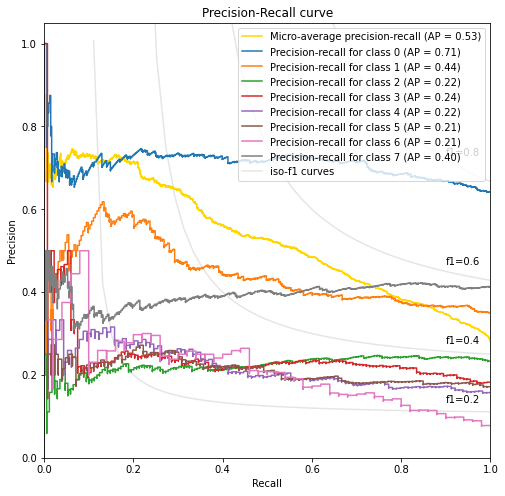

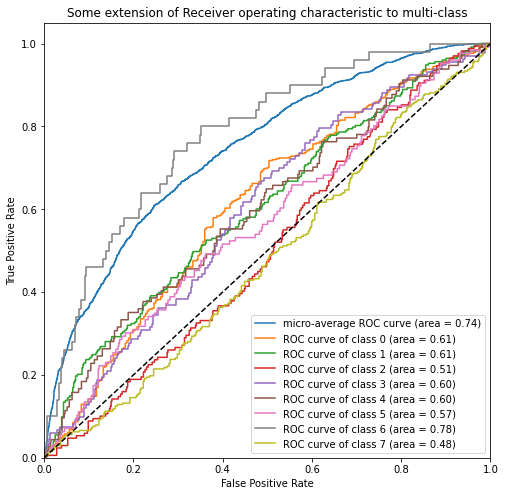

RandomForestClassifier(random_state=1):
Accuracy: 0.050340136054421766
Hamming Loss: 0.3171768707482993
Brier Score: 1.8674524064345832
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.66      0.67       471
           1       0.41      0.38      0.39       253
           2       0.23      0.21      0.22       169
           3       0.21      0.20      0.20       133
           4       0.19      0.19      0.19       114
           5       0.21      0.16      0.18       126
           6       0.15      0.22      0.18        50
           7       0.45      0.43      0.44       303

   micro avg       0.42      0.40      0.41      1619
   macro avg       0.31      0.31      0.31      1619
weighted avg       0.42      0.40      0.41      1619
 samples avg       0.50      0.46      0.35      1619

Confusion matrix:
 [[[111 153]
  [160 311]]

 [[343 139]
  [157  96]]

 [[450 116]
  [134  35]]

 [[503  99]
  [107  26]]

 [[527  94]


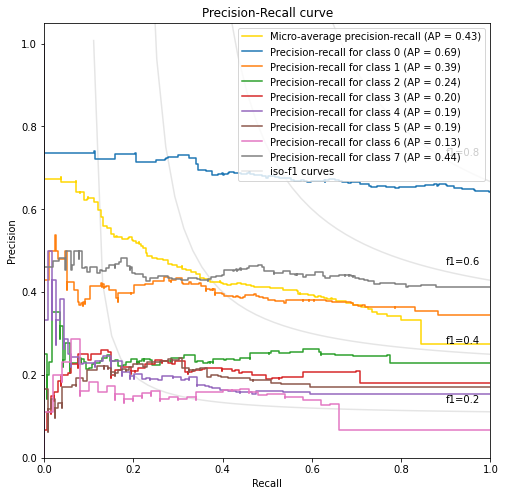

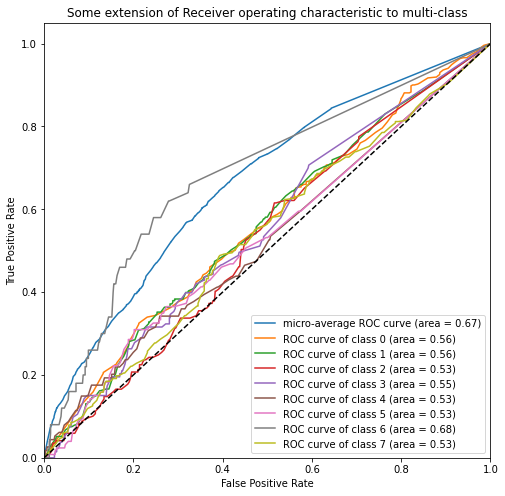

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
forest = RandomForestClassifier(random_state=1)
lg = LogisticRegression()
models = [lg, forest]

for model in models:

    multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
    multi_output_model.fit(train_features, train_labels)
    predicted_labels = np.asarray(multi_output_model.predict_proba(test_features))[:, :, 1].T
    print(str(model)+':')
    evaluate(test_labels, predicted_labels)
    plot_pr_curve(test_labels, predicted_labels)
    plot_roc_curve(test_labels, predicted_labels)

### MLP simple

2021-11-30 18:17:23.373503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-30 18:17:23.396570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 18:17:23.397238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:06.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-11-30 18:17:23.397486: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-30 18:17:23.398723: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-30 18:17:23.400074: I tensorflow/stream_executor/platform/default/d

Epoch 1/100
 1/69 [..............................] - ETA: 0s - loss: 0.7282

2021-11-30 18:17:24.285416: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


69/69 [==============================] - 0s 2ms/step - loss: 0.6500
Epoch 2/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5568
Epoch 3/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5336
Epoch 4/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5237
Epoch 5/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5173
Epoch 6/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5135
Epoch 7/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5107
Epoch 8/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5090
Epoch 9/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5074
Epoch 10/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5064
Epoch 11/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5055
Epoch 12/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5052
Epoch 13/100
69/69 [=============================

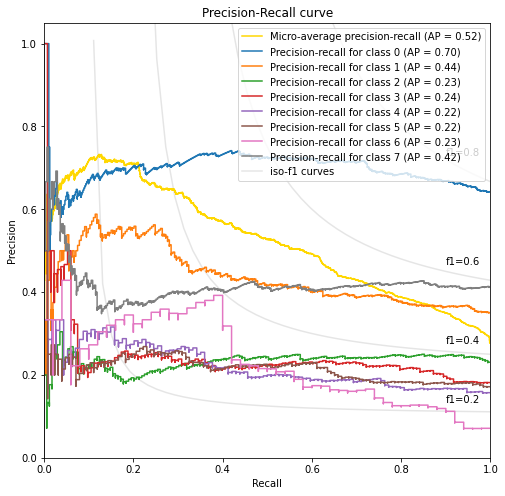

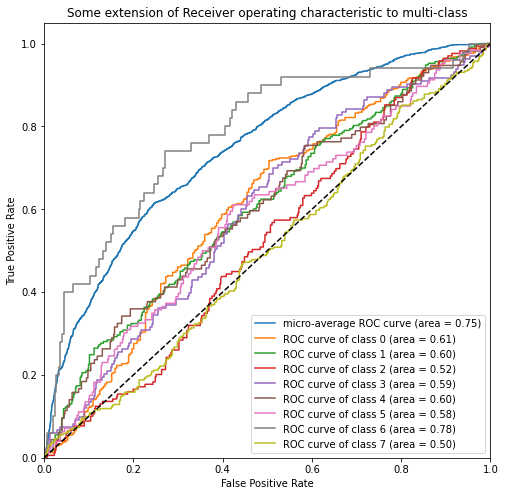

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(64, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

## MLP more complicated

Epoch 1/100
69/69 [==============================] - 0s 1ms/step - loss: 0.6038
Epoch 2/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5261
Epoch 3/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5175
Epoch 4/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5129
Epoch 5/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5093
Epoch 6/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5072
Epoch 7/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5060
Epoch 8/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5050
Epoch 9/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5049
Epoch 10/100
69/69 [==============================] - 0s 2ms/step - loss: 0.5039
Epoch 11/100
69/69 [==============================] - 0s 2ms/step - loss: 0.5039
Epoch 12/100
69/69 [==============================] - 0s 1ms/step - loss: 0.5033
Epoch 13/100
69/69 [=================

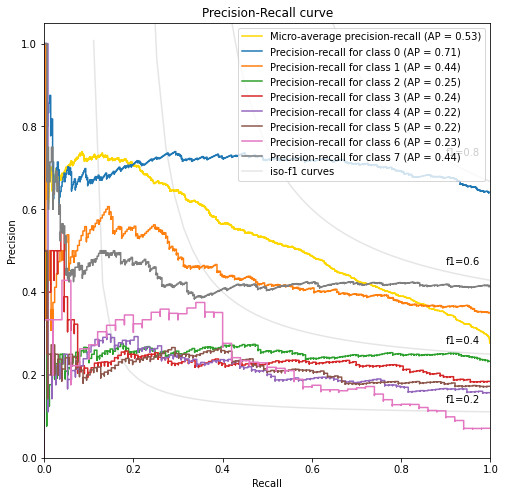

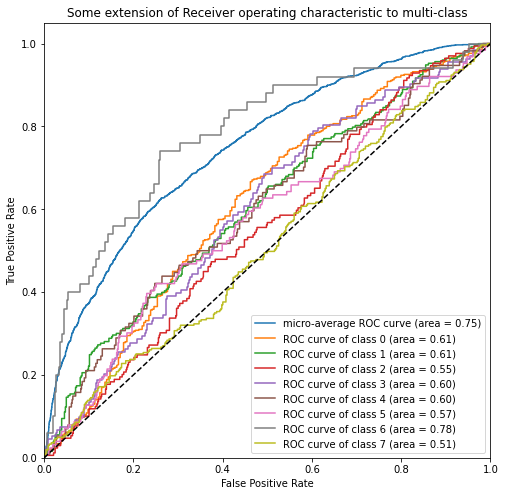

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_mlp(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

n_inputs, n_outputs = train_features.shape[1],train_labels.shape[1]
mlp = get_mlp(n_inputs, n_outputs)
mlp.fit(train_features, train_labels, verbose=1, epochs=100)

predicted_labels_mlp = mlp.predict(test_features)
evaluate(test_labels, predicted_labels_mlp)

plot_pr_curve(test_labels, predicted_labels_mlp)
plot_roc_curve(test_labels, predicted_labels_mlp)

### Binary Relevance
ignores the possible correlations between class labels

Accuracy: 0.1401360544217687
Hamming Loss: 0.23826530612244898
Brier Score: 1.346353782497964
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.86      0.76       471
           1       0.59      0.13      0.21       253
           2       1.00      0.00      0.00       169
           3       1.00      0.00      0.00       133
           4       1.00      0.00      0.00       114
           5       1.00      0.00      0.00       126
           6       0.23      0.10      0.14        50
           7       0.46      0.04      0.07       303

   micro avg       0.66      0.28      0.39      1619
   macro avg       0.75      0.14      0.15      1619
weighted avg       0.72      0.28      0.27      1619
 samples avg       0.72      0.38      0.39      1619

Confusion matrix:
 [[[ 82 182]
  [ 67 404]]

 [[459  23]
  [220  33]]

 [[566   0]
  [169   0]]

 [[602   0]
  [133   0]]

 [[621   0]
  [114   0]]

 [[609   0]
  [126   0]]

 [

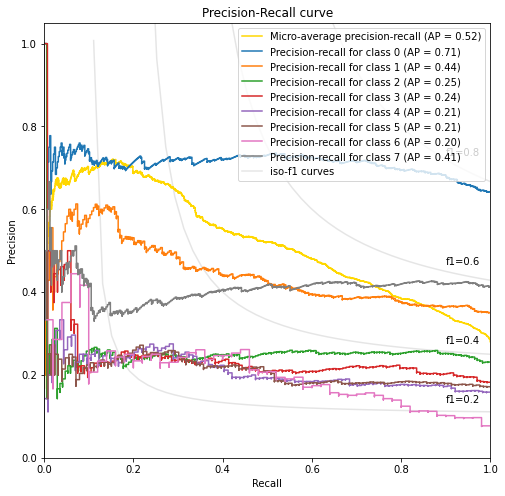

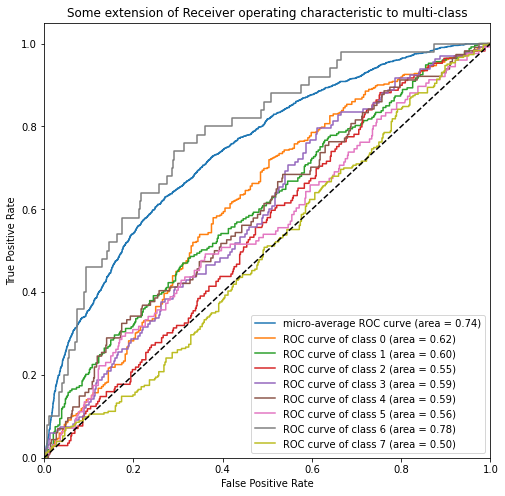

In [46]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

classifier = BinaryRelevance(GaussianNB())
classifier.fit(train_features, train_labels)


predicted_labels_br = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_br.toarray())

plot_pr_curve(test_labels, predicted_labels_br.toarray())
plot_roc_curve(test_labels, predicted_labels_br.toarray())

### Classfier Chains

Accuracy: 0.1292517006802721
Hamming Loss: 0.2413265306122449
Brier Score: 1.374075436309091
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.87      0.76       471
           1       0.44      0.03      0.05       253
           2       1.00      0.00      0.00       169
           3       1.00      0.00      0.00       133
           4       1.00      0.00      0.00       114
           5       1.00      0.00      0.00       126
           6       0.31      0.10      0.15        50
           7       0.00      0.00      0.00       303

   micro avg       0.66      0.26      0.37      1619
   macro avg       0.68      0.12      0.12      1619
weighted avg       0.61      0.26      0.23      1619
 samples avg       0.71      0.36      0.37      1619

Confusion matrix:
 [[[ 63 201]
  [ 61 410]]

 [[473   9]
  [246   7]]

 [[566   0]
  [169   0]]

 [[602   0]
  [133   0]]

 [[621   0]
  [114   0]]

 [[609   0]
  [126   0]]

 [[

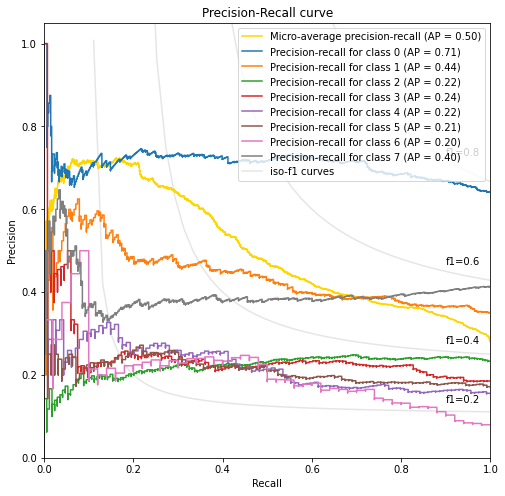

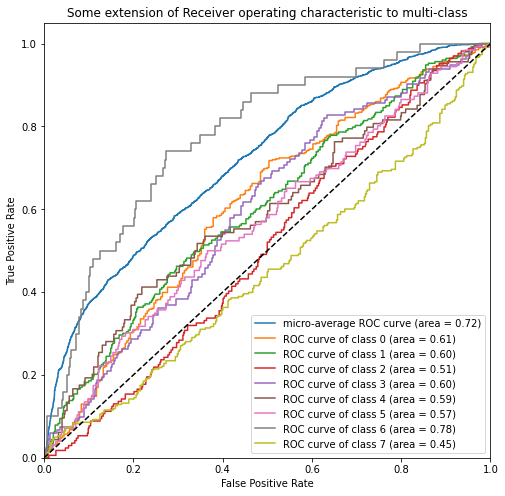

In [47]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

classifier = ClassifierChain(LogisticRegression())
classifier.fit(train_features, train_labels)
# we should optimise this a little

predicted_labels_cc = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_cc.toarray())

plot_pr_curve(test_labels, predicted_labels_cc.toarray())
plot_roc_curve(test_labels, predicted_labels_cc.toarray())

### Label Powerset
takes correlations into account!

Accuracy: 0.12653061224489795
Hamming Loss: 0.2392857142857143
Brier Score: 1.339039550304384
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.94      0.77       471
           1       0.43      0.01      0.02       253
           2       1.00      0.00      0.00       169
           3       1.00      0.00      0.00       133
           4       1.00      0.00      0.00       114
           5       1.00      0.00      0.00       126
           6       1.00      0.00      0.00        50
           7       1.00      0.00      0.00       303

   micro avg       0.66      0.27      0.39      1619
   macro avg       0.89      0.12      0.10      1619
weighted avg       0.81      0.27      0.23      1619
 samples avg       0.68      0.38      0.38      1619

Confusion matrix:
 [[[ 35 229]
  [ 29 442]]

 [[478   4]
  [250   3]]

 [[566   0]
  [169   0]]

 [[602   0]
  [133   0]]

 [[621   0]
  [114   0]]

 [[609   0]
  [126   0]]

 [

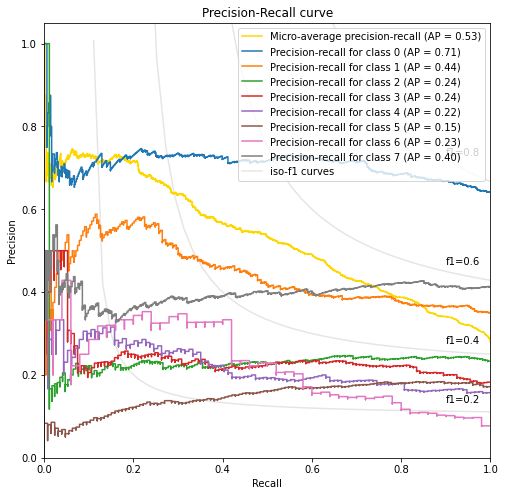

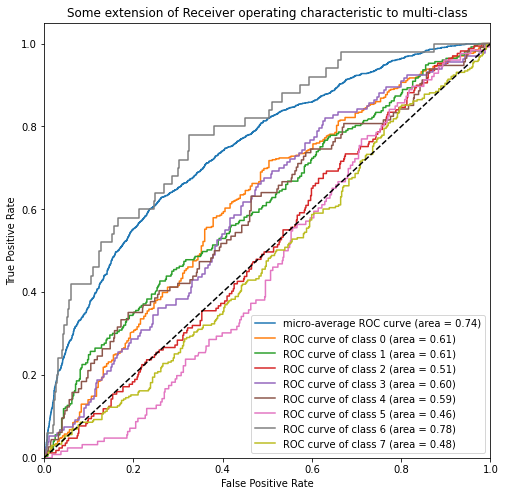

In [48]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(LogisticRegression())
classifier.fit(train_features, train_labels)

predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())

Accuracy: 0.050340136054421766
Hamming Loss: 0.3175170068027211
Brier Score: 1.8641598895834295
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.66      0.66       471
           1       0.41      0.38      0.39       253
           2       0.23      0.21      0.22       169
           3       0.21      0.20      0.20       133
           4       0.19      0.19      0.19       114
           5       0.21      0.16      0.18       126
           6       0.15      0.22      0.18        50
           7       0.45      0.43      0.44       303

   micro avg       0.42      0.40      0.41      1619
   macro avg       0.31      0.31      0.31      1619
weighted avg       0.42      0.40      0.41      1619
 samples avg       0.50      0.46      0.35      1619

Confusion matrix:
 [[[111 153]
  [162 309]]

 [[344 138]
  [157  96]]

 [[450 116]
  [134  35]]

 [[502 100]
  [107  26]]

 [[527  94]
  [ 92  22]]

 [[533  76]
  [106  20]]



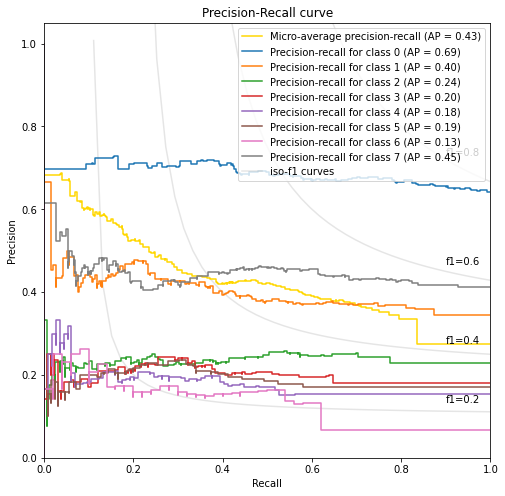

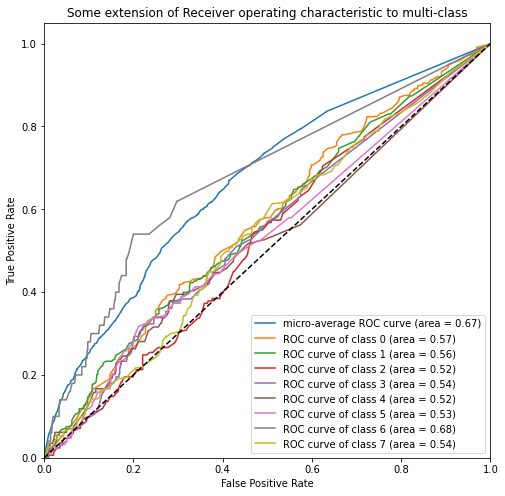

In [49]:
from skmultilearn.problem_transform import LabelPowerset

classifier = LabelPowerset(RandomForestClassifier())
classifier.fit(train_features, train_labels)

predicted_labels_lp = classifier.predict_proba(test_features)
evaluate(test_labels, predicted_labels_lp.toarray())

plot_pr_curve(test_labels, predicted_labels_lp.toarray())
plot_roc_curve(test_labels, predicted_labels_lp.toarray())